In [1]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from threading import Thread
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import pickle
import random
from tqdm import tqdm
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
init_notebook_mode(connected=True)


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')


NO CORRER LA SIGUIENTE CELDA

In [4]:
#import zipfile
#import os

# Ruta del archivo ZIP en tu Google Drive
#zip_path = '/content/drive/Shareddrives/Redes 2024_1/Trabajo 3/archive.zip'

# Ruta donde deseas extraer los archivos
#extract_to = '/content/drive/Shareddrives/Redes 2024_1/Trabajo 3/extracted_files'

# Crear el directorio si no existe
#os.makedirs(extract_to, exist_ok=True)

# Descomprimir el archivo
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_to)

#print(f'Archivos extraídos en: {extract_to}')


In [3]:


styles_df = pd.read_csv("styles.csv", on_bad_lines='skip')


In [4]:
styles_df['filename'] = styles_df['id'].astype(str) + '.jpg'


In [5]:
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg


NOta: primero cambiar images por pruebas y correr, luego volver a poner images y ahi si lee todas las direcciones, es raro al verdad

In [6]:
image_files = os.listdir("extracted_files/images")

In [7]:
len(image_files)

35969

In [8]:
image_files[:5]

['10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg']

In [9]:
import os

def check_image_path(filename):
    path = os.path.join("extracted_files/images", filename)
    return path if os.path.exists(path) else None

styles_df['filename'] = styles_df['filename'].apply(check_image_path)


In [10]:
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,extracted_files/images\15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,extracted_files/images\39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,None
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,extracted_files/images\21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,extracted_files/images\53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,extracted_files/images\17036.jpg
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,None
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,extracted_files/images\18842.jpg
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,extracted_files/images\46694.jpg


In [13]:

# Filtrar filas donde la imagen no existe
styles_df = styles_df[styles_df['filename'].notnull()]

In [14]:
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/content/drive/Shareddrives/Redes 2024_1/Traba...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/content/drive/Shareddrives/Redes 2024_1/Traba...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...
...,...,...,...,...,...,...,...,...,...,...,...
44418,42234,Women,Apparel,Topwear,Tops,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top,/content/drive/Shareddrives/Redes 2024_1/Traba...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,/content/drive/Shareddrives/Redes 2024_1/Traba...
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,/content/drive/Shareddrives/Redes 2024_1/Traba...
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,/content/drive/Shareddrives/Redes 2024_1/Traba...


Verificando que todas las imagenes esten

In [15]:
styles_df['file_found'] = styles_df['id'].apply(lambda x: f"{x}.jpg" in image_files)

<ipython-input-15-63a28c3c8549>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
...,...,...,...,...,...,...,...,...,...,...,...,...
44418,42234,Women,Apparel,Topwear,Tops,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,/content/drive/Shareddrives/Redes 2024_1/Traba...,True


In [17]:
styles_df = styles_df[styles_df['file_found']].reset_index(drop=True)

In [18]:
styles_df.shape[0]

35948

## Base de datos final

In [19]:
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
2,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
3,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
4,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
...,...,...,...,...,...,...,...,...,...,...,...,...
35943,42234,Women,Apparel,Topwear,Tops,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
35944,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
35945,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
35946,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,/content/drive/Shareddrives/Redes 2024_1/Traba...,True


 Checking for Null Values

In [20]:
styles_df.isnull().sum()


id                     0
gender                 0
masterCategory         0
subCategory            0
articleType            0
baseColour            14
season                21
year                   1
usage                 75
productDisplayName     7
filename               0
file_found             0
dtype: int64

In [21]:
# Eliminamos las filas que contienen valores faltantes
styles_df_clean = styles_df.dropna()

# Revisamos nuevamente la cantidad de valores nulos en cada columna para asegurarnos de que se han eliminado
print(styles_df_clean.isnull().sum())

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
filename              0
file_found            0
dtype: int64


In [22]:
styles_df_clean

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
2,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
3,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
4,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
...,...,...,...,...,...,...,...,...,...,...,...,...
35943,42234,Women,Apparel,Topwear,Tops,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
35944,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
35945,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,/content/drive/Shareddrives/Redes 2024_1/Traba...,True
35946,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,/content/drive/Shareddrives/Redes 2024_1/Traba...,True


La base de datos final quedo con 35844

# analísis descriptivo


In [23]:

fig = px.bar(styles_df_clean.groupby('masterCategory').count().reset_index(), x='masterCategory',y='id',title='Count per Product Category')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

# Desarrollo del modelo


In [24]:
styles_df_clean.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName',
       'filename', 'file_found'],
      dtype='object')

In [25]:
styles_df_clean.drop(columns=['productDisplayName','file_found'],inplace=True)


<ipython-input-25-c8380e00522c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
styles_df_clean.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'filename'],
      dtype='object')

In [27]:
styles_df_clean = styles_df_clean.sample(frac=1).reset_index(drop=True)
n = len(styles_df_clean)
train = styles_df_clean.iloc[:int(n*0.8),:]
val = styles_df_clean.iloc[int(n*0.8):,:].reset_index(drop=True)

In [28]:
# Crear una muestra de 5000 filas para el conjunto de entrenamiento
train_sampled = train.sample(n=1000, random_state=42).reset_index(drop=True)

# Crear una muestra de 1000 filas para el conjunto de validación
val_sampled = val.sample(n=200, random_state=42).reset_index(drop=True)


In [29]:
datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_dataframe(dataframe=train_sampled,
                                             target_size=(256,256),
                                             x_col='filename',
                                             class_mode=None,
                                             batch_size=32,
                                             shuffle=False,
                                             classes=['images'])

val_generator = datagen.flow_from_dataframe(dataframe=val_sampled,
                                             target_size=(256,256),
                                             x_col='filename',
                                             class_mode=None,
                                             batch_size=32,
                                             shuffle=False,
                                             classes=['images'])

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1071: UserWarning:

`classes` will be ignored given the class_mode="None"



Found 1000 validated image filenames.
Found 200 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1071: UserWarning:

`classes` will be ignored given the class_mode="None"



In [30]:
train_generator

**Una muestra de imagen entrenamiento**

(32, 256, 256, 3)


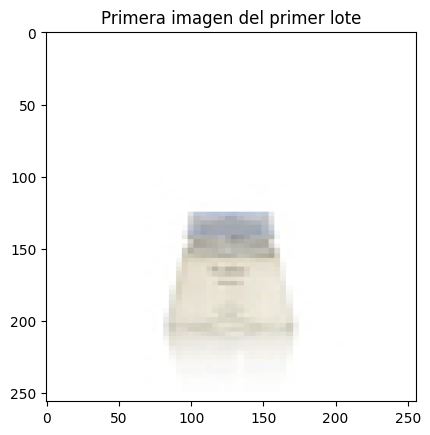

In [31]:
# Obtener el primer lote de imágenes
images_batch = next(train_generator)
# Imprimir la forma del lote de imágenes
print(images_batch.shape)  # Debe ser (32, 256, 256, 3) si batch_size=32 y las imágenes son RGB
# Mostrar la primera imagen del lote
import matplotlib.pyplot as plt
plt.imshow(images_batch[0])
plt.title('Primera imagen del primer lote')
plt.show()

**muestra de una imagen de entrenamiento**

(32, 256, 256, 3)


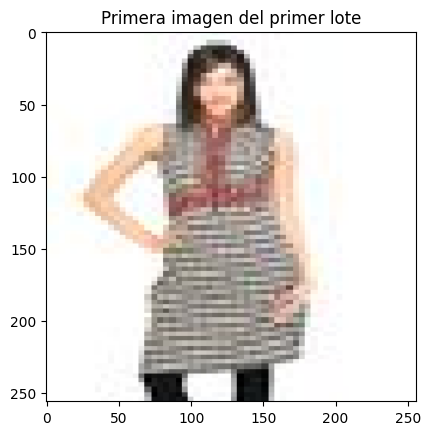

In [32]:
# Obtener el primer lote de imágenes
images_batch = next(val_generator)
# Imprimir la forma del lote de imágenes
print(images_batch.shape)  # Debe ser (32, 256, 256, 3) si batch_size=32 y las imágenes son RGB
# Mostrar la primera imagen del lote
import matplotlib.pyplot as plt
plt.imshow(images_batch[0])
plt.title('Primera imagen del primer lote')
plt.show()


In [33]:
base_model = VGG16(include_top=False,input_shape=(256,256,3))

model = Sequential()
for layer in base_model.layers:
    model.add(layer)
model.add(GlobalAveragePooling2D())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [34]:

train_features = model.predict(train_generator,verbose=1)


32/32 [==============================] - 829s 26s/step


In [35]:

val_features = model.predict(val_generator,verbose=1)

7/7 [==============================] - 164s 23s/step


Guardar los objetos

In [36]:
import pickle

# Especificar la ruta para guardar los archivos
train_features_path = '/content/drive/Shareddrives/Redes 2024_1/Trabajo 3/train_features.pkl'
val_features_path = '/content/drive/Shareddrives/Redes 2024_1/Trabajo 3/val_features.pkl'

# Guardar train_features en un archivo .pkl
with open(train_features_path, 'wb') as f:
    pickle.dump(train_features, f)

# Guardar val_features en un archivo .pkl
with open(val_features_path, 'wb') as f:
    pickle.dump(val_features, f)


# llamar lo objetos cargados

In [ ]:
import pickle

# Especificar la ruta para cargar los archivos
train_features_path = '/content/drive/Shareddrives/Redes 2024_1/Trabajo 3/train_features.pkl'
val_features_path = '/content/drive/Shareddrives/Redes 2024_1/Trabajo 3/val_features.pkl'

# Cargar train_features desde el archivo .pkl
with open(train_features_path, 'rb') as f:
    train_features = pickle.load(f)

# Cargar val_features desde el archivo .pkl
with open(val_features_path, 'rb') as f:
    val_features = pickle.load(f)


In [37]:
from sklearn.decomposition import PCA


In [38]:
pca = PCA(2)
pca.fit(train_features)
train_pca = pca.transform(train_features)

In [39]:
test_pca = pca.fit_transform(val_features)


In [40]:
train_pca = pd.DataFrame(train_pca)
train = train.iloc[:,0:10]
train = train.merge(train_pca, how='left', left_index=True, right_index=True)

In [ ]:
fig = px.scatter(train, x=0, y=1, color="masterCategory", title='Main Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [ ]:
fig = px.scatter(train, x=0, y=1, color="gender", title='Gender', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [ ]:
fig = px.scatter(train, x=0, y=1, color="subCategory", title='Sub Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [ ]:
pca = PCA()
pca.fit(train_features)

In [41]:

train_pca = pca.transform(train_features)
variance_explained = np.cumsum(pca.explained_variance_ratio_)
pcs = range(1,len(variance_explained)+1)

In [ ]:
px.line(x = pcs, y = variance_explained, title = 'Principal Components Cumulative Explained Variance', height=600,  labels={
                     "x": "Principal Components",
                     "y": "Explained Variance"})

In [82]:

# Especificar la ruta para guardar el modelo PCA
pca_model_path = '/content/drive/Shareddrives/Redes 2024_1/Trabajo 3/pca_model.pkl'

# Guardar el modelo PCA en un archivo .pkl
with open(pca_model_path, 'wb') as f:
    pickle.dump(pca, f)

# Cargar el modelo PCA desde el archivo .pkl
# with open(pca_model_path, 'rb') as f:
#     loaded_pca = pickle.load(f)

In [57]:
val_pca = pca.fit_transform(val_features)#[:,:313]
val_pca = pd.DataFrame(val_pca)

In [56]:
val_pca

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.730839,-0.167654,-0.131516,-0.255666,-0.075433,0.308379,0.362771,-0.139672,0.305828,-0.280046,...,0.000064,0.003244,-0.004954,0.000542,-0.000758,0.009631,-0.016218,0.005152,0.004331,0.000002
1,0.599014,0.168791,-0.010533,-0.233351,0.598010,-0.043032,0.155682,-0.172289,-0.221855,0.126600,...,-0.015513,0.003470,-0.001095,0.015092,-0.001347,0.020223,-0.001882,-0.004586,-0.002353,0.000002
2,0.653614,-0.600946,-0.095003,-0.565733,-0.340351,0.328417,0.015498,-0.264333,0.225447,-0.102401,...,0.003138,-0.012617,0.002413,0.005113,-0.003049,-0.012428,-0.005104,-0.012180,0.008633,0.000002
3,0.802585,-0.596027,-0.947738,0.276103,0.412393,-0.099789,0.450434,-0.276901,-0.404676,0.160762,...,0.004262,-0.008033,0.001175,0.006440,-0.001781,0.005355,-0.002025,-0.002232,0.004757,0.000002
4,-0.790618,0.363768,0.613816,-0.497275,0.132413,-0.363621,-0.229967,-0.110803,0.182105,-0.407306,...,0.017457,0.013448,0.004456,-0.005332,-0.002166,-0.021400,-0.002322,0.003786,0.003003,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.284428,-0.138328,0.136332,0.208697,-0.175223,0.095344,0.514811,-0.225686,-0.039901,-0.436274,...,0.014137,0.004672,-0.008015,0.007623,-0.008696,0.004461,0.001033,0.005531,0.006350,0.000002
196,1.264919,-0.699775,0.101921,-0.024703,-0.021214,-0.149940,0.013020,0.180797,-0.073887,-0.179642,...,0.000883,0.000394,-0.011573,-0.020873,-0.003607,-0.005529,0.000965,0.006293,-0.000266,0.000002
197,0.466129,-0.556988,-1.100900,-0.327826,0.279783,0.251790,0.112656,-0.328436,0.001346,-0.298069,...,0.008796,0.004218,0.001061,0.004030,0.017779,-0.000340,0.007977,0.004721,-0.003148,0.000002
198,-0.866990,-0.783649,-0.421850,0.019383,-0.460061,0.149886,0.424335,0.057149,-0.314701,-0.032487,...,0.004188,0.003421,-0.001269,0.012604,0.012294,0.005905,-0.003270,-0.009038,-0.001881,0.000002


In [58]:
val_sampled

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,filename
0,15104,Women,Apparel,Topwear,Kurtas,Black,Fall,2011.0,Ethnic,/content/drive/Shareddrives/Redes 2024_1/Traba...
1,2659,Women,Accessories,Bags,Handbags,Brown,Winter,2015.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...
2,21443,Women,Apparel,Topwear,Tshirts,Blue,Winter,2012.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...
3,2169,Men,Apparel,Topwear,Shirts,Red,Summer,2011.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...
4,17865,Men,Apparel,Innerwear,Briefs,Green,Summer,2016.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...
...,...,...,...,...,...,...,...,...,...,...
195,20666,Men,Apparel,Topwear,Tshirts,Grey,Fall,2011.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...
196,17279,Men,Apparel,Topwear,Tshirts,Navy Blue,Fall,2011.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...
197,35031,Women,Accessories,Stoles,Stoles,Blue,Summer,2012.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...
198,15855,Unisex,Footwear,Sandal,Sandals,Grey,Fall,2012.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...


In [59]:

val = val_sampled.iloc[:,0:10]

In [60]:

val = val.merge(val_pca, how='left', left_index=True, right_index=True)

In [61]:
val

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,filename,...,190,191,192,193,194,195,196,197,198,199
0,15104,Women,Apparel,Topwear,Kurtas,Black,Fall,2011.0,Ethnic,/content/drive/Shareddrives/Redes 2024_1/Traba...,...,0.000064,0.003244,-0.004954,0.000542,-0.000758,0.009631,-0.016218,0.005152,0.004331,0.000002
1,2659,Women,Accessories,Bags,Handbags,Brown,Winter,2015.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...,...,-0.015513,0.003470,-0.001095,0.015092,-0.001347,0.020223,-0.001882,-0.004586,-0.002353,0.000002
2,21443,Women,Apparel,Topwear,Tshirts,Blue,Winter,2012.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...,...,0.003138,-0.012617,0.002413,0.005113,-0.003049,-0.012428,-0.005104,-0.012180,0.008633,0.000002
3,2169,Men,Apparel,Topwear,Shirts,Red,Summer,2011.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...,...,0.004262,-0.008033,0.001175,0.006440,-0.001781,0.005355,-0.002025,-0.002232,0.004757,0.000002
4,17865,Men,Apparel,Innerwear,Briefs,Green,Summer,2016.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...,...,0.017457,0.013448,0.004456,-0.005332,-0.002166,-0.021400,-0.002322,0.003786,0.003003,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,20666,Men,Apparel,Topwear,Tshirts,Grey,Fall,2011.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...,...,0.014137,0.004672,-0.008015,0.007623,-0.008696,0.004461,0.001033,0.005531,0.006350,0.000002
196,17279,Men,Apparel,Topwear,Tshirts,Navy Blue,Fall,2011.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...,...,0.000883,0.000394,-0.011573,-0.020873,-0.003607,-0.005529,0.000965,0.006293,-0.000266,0.000002
197,35031,Women,Accessories,Stoles,Stoles,Blue,Summer,2012.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...,...,0.008796,0.004218,0.001061,0.004030,0.017779,-0.000340,0.007977,0.004721,-0.003148,0.000002
198,15855,Unisex,Footwear,Sandal,Sandals,Grey,Fall,2012.0,Casual,/content/drive/Shareddrives/Redes 2024_1/Traba...,...,0.004188,0.003421,-0.001269,0.012604,0.012294,0.005905,-0.003270,-0.009038,-0.001881,0.000002


In [64]:
X = val.iloc[:,-200:]
y = val['id']

In [ ]:
y

In [69]:
from sklearn.neighbors import KNeighborsClassifier
import pickle

# Suponiendo que X e y ya están definidos
# Especificar la ruta para guardar el modelo
knn_model_path = '/content/drive/Shareddrives/Redes 2024_1/Trabajo 3/knn_model.pkl'

# Entrenar el modelo KNN
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X, y)

# Guardar el modelo KNN en un archivo .pkl
with open(knn_model_path, 'wb') as f:
    pickle.dump(neigh, f)

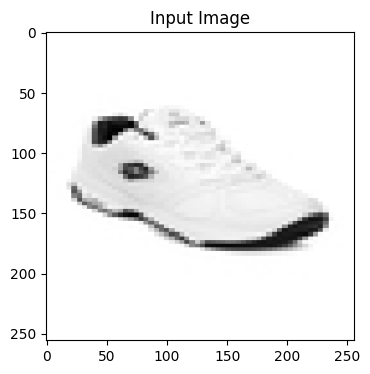

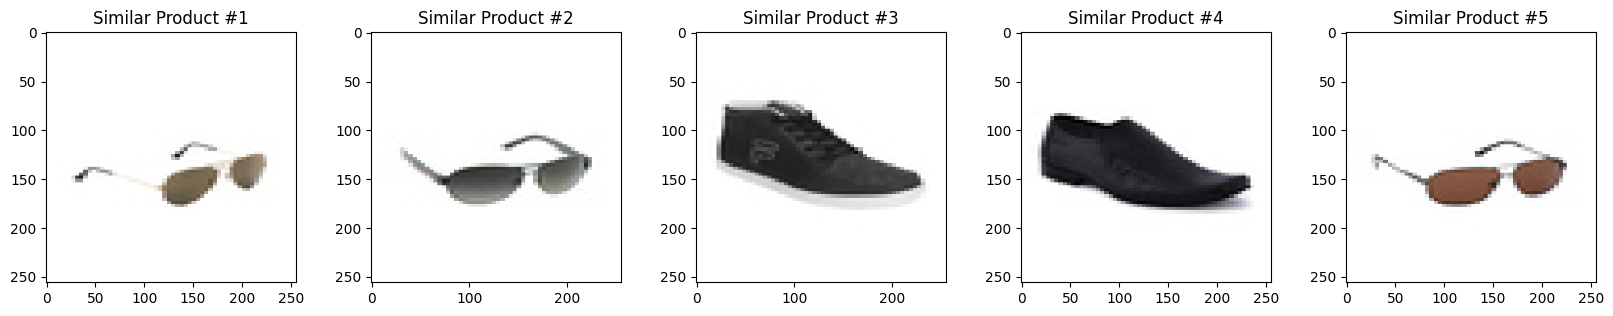

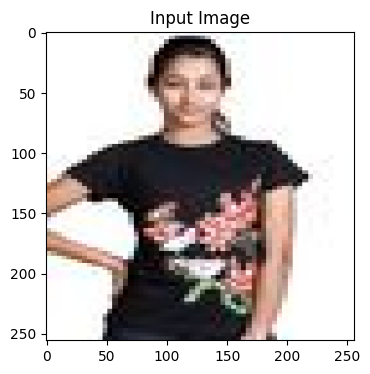

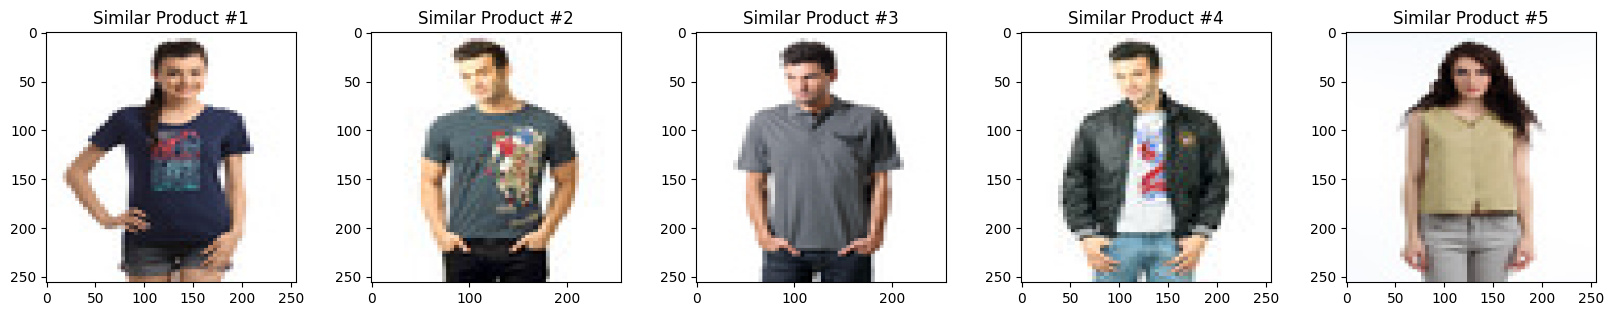

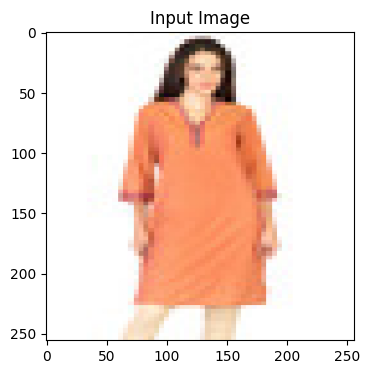

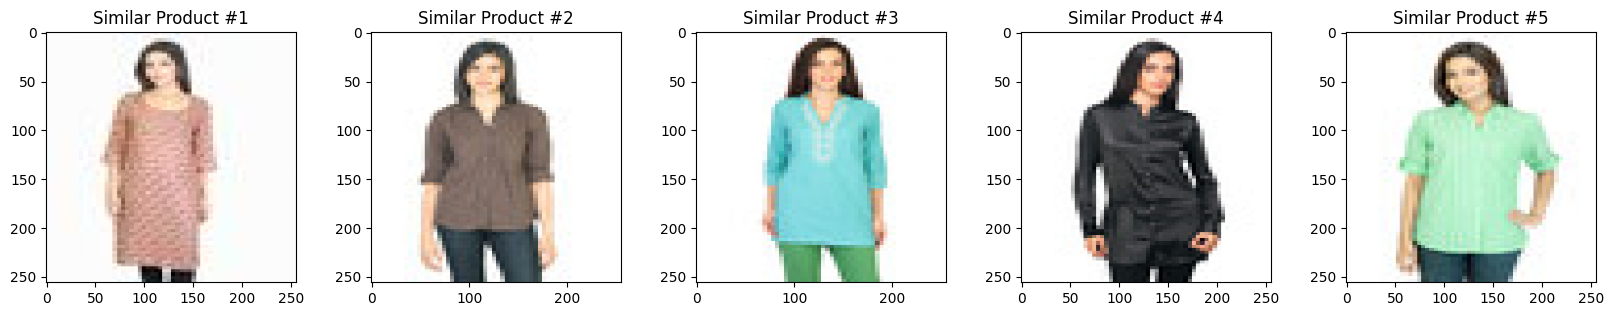

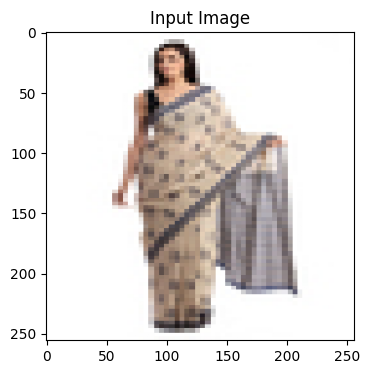

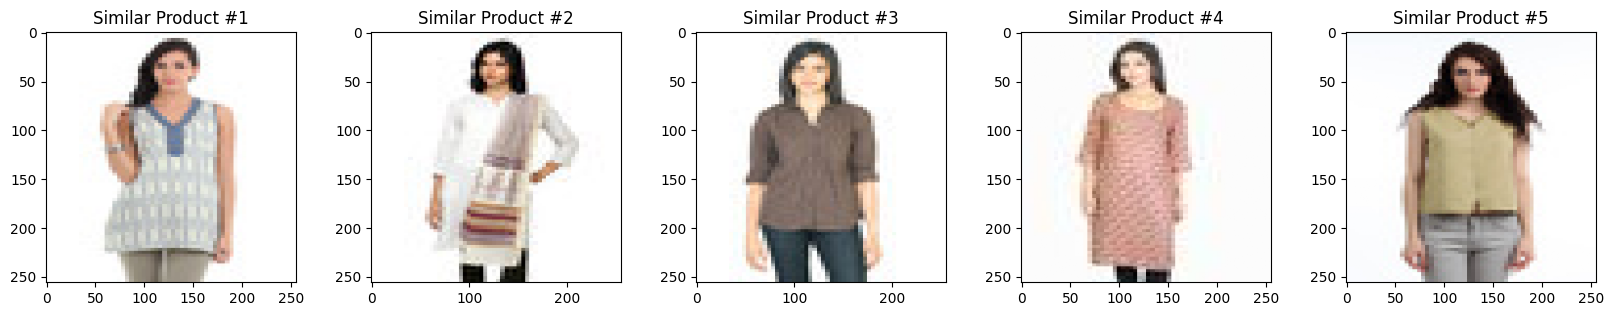

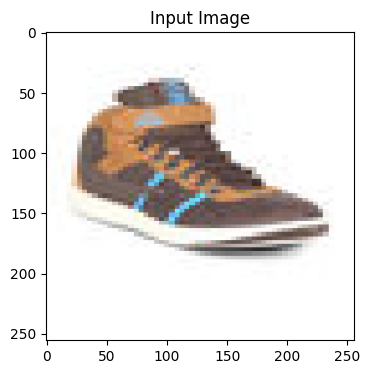

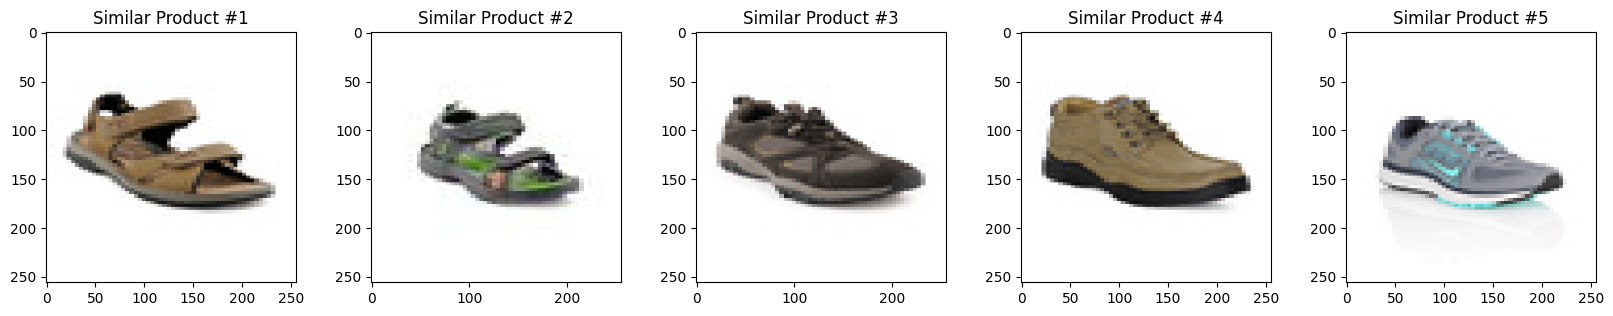

In [70]:
# for _ in range(5):
#     i = random.randint(1,len(val))
#     img1 = read_img(val_sampled.loc[i,'filename'])
#     dist, index = neigh.kneighbors(X=X.iloc[i,:].values.reshape(1,-1))
#     plt.figure(figsize = (4 , 4))
#     plt.imshow(img1)
#     plt.title("Input Image")

#     plt.figure(figsize = (20 , 20))
#     for i in range(1,6):
#         plt.subplot(1 , 5, i)
#         plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
#         image = read_img(val_sampled.loc[index[0][i],'filename'])
#         plt.imshow(image)
#         plt.title(f'Similar Product #{i}')

## implementación del modelo

In [80]:

# Función para leer y procesar una imagen
def read_img(image_path):
    image = load_img(image_path, target_size=(256, 256, 3))
    image = img_to_array(image)
    image = image / 255.0
    return image

# Función para recomendar productos similares
def recommend_similar_products(input_image_path, model, pca, neigh, val_sampled, num_recommendations=5):
    # Leer y procesar la imagen de entrada proporcionada por el usuario
    img1 = read_img(input_image_path)

    # Extraer características visuales de la imagen de entrada utilizando el modelo preentrenado
    img_features = model.predict(np.expand_dims(img1, axis=0))

    # Aplicar PCA a las características de la imagen de entrada
    img_features_pca = pca.transform(img_features)

    # Encontrar las imágenes más similares en el dataset utilizando KNN
    dist, index = neigh.kneighbors(img_features_pca)

    # Visualizar la imagen de entrada
    plt.figure(figsize=(4, 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.show()

    # Visualizar las imágenes más similares del dataset
    plt.figure(figsize=(20, 20))
    for i in range(1, num_recommendations + 1):
        plt.subplot(1, num_recommendations, i)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        similar_image_path = val_sampled.loc[index[0][i-1], 'filename']
        similar_image = read_img(similar_image_path)
        plt.imshow(similar_image)
        plt.title(f'Similar Product #{i}')
    plt.show()


1/1 [==============================] - 2s 2s/step


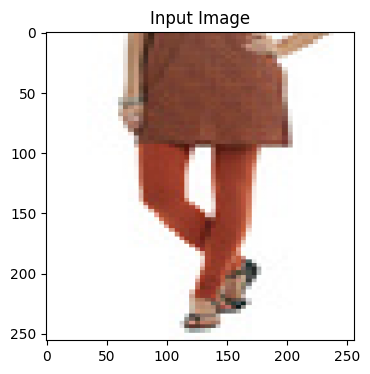

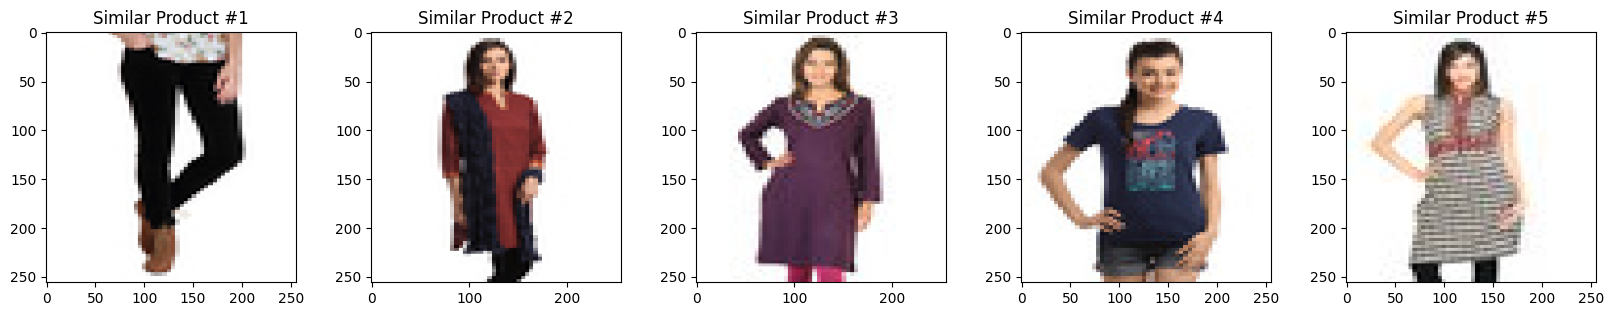

In [84]:


# Ejemplo de uso de la función
input_image_path = '/content/drive/Shareddrives/Redes 2024_1/Trabajo 3/extracted_files/pruebas/54055.jpg'

# Llamar a la función de recomendación
recommend_similar_products(input_image_path, model, pca, neigh, val_sampled, num_recommendations=5)
